<a href="https://colab.research.google.com/github/M-kaur07/Hardware_Trojan_Detection_GNN/blob/main/SCOAP_aes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving .restartSimSession.tcl.old to .restartSimSession.tcl.old
Saving aes_synth.v to aes_synth.v
Saving aes_synth_opt.v to aes_synth_opt.v
Saving Read_Me.txt to Read_Me.txt
Saving run_tj to run_tj
Saving run_tjfree to run_tjfree
Saving tbTOP.v to tbTOP.v
Saving test_aes_128.v to test_aes_128.v


In [ ]:
verilog_file = "aes_synth.v"

In [ ]:
import re

def manual_gate_parser(verilog_file):
    gates = []

    with open(verilog_file, 'r') as f:
        lines = f.readlines()

    gate_pattern = re.compile(r'(\w+)\s+(\w+)\s*\((.*?)\);')

    for line in lines:
        line = line.strip()
        match = gate_pattern.match(line)
        if match:
            gate_type = match.group(1)
            gate_name = match.group(2)
            raw_ports = match.group(3)

            ports = re.findall(r'\.(\w+)\(([\w\d_]+)\)', raw_ports)
            connections = {port: wire for port, wire in ports}

            # ✅ Skip non-gates like 'module' or entries with no connections
            if gate_type.lower() == "module" or not connections:
                continue

            gates.append({
                'gate_type': gate_type,
                'gate_name': gate_name,
                'connections': connections
            })

    return gates


In [ ]:
gates = manual_gate_parser(verilog_file)
print("Total gates parsed:", len(gates))
for g in gates[:5]:
    print(g)


Total gates parsed: 113255
{'gate_type': 'NAND4X0', 'gate_name': 'U3', 'connections': {'IN1': 'n1', 'IN2': 'n2', 'IN3': 'n3', 'IN4': 'n4', 'QN': 'N870'}}
{'gate_type': 'OA221X1', 'gate_name': 'U4', 'connections': {'IN1': 'n5', 'IN2': 'n6', 'IN3': 'n7', 'IN4': 'n8', 'IN5': 'n9', 'Q': 'n4'}}
{'gate_type': 'OA22X1', 'gate_name': 'U5', 'connections': {'IN1': 'n10', 'IN2': 'n11', 'IN3': 'n12', 'IN4': 'n13', 'Q': 'n9'}}
{'gate_type': 'NOR2X0', 'gate_name': 'U6', 'connections': {'IN1': 'n14', 'IN2': 'n15', 'QN': 'n7'}}
{'gate_type': 'NOR2X0', 'gate_name': 'U7', 'connections': {'IN1': 'n16', 'IN2': 'n17', 'QN': 'n5'}}


In [ ]:
import networkx as nx

def build_gate_graph(gates):
    G = nx.DiGraph()

    # Step 1: Add all gates as nodes
    for gate in gates:
        G.add_node(gate['gate_name'], gate_type=gate['gate_type'])

    # Step 2: Add edges based on shared wires (from output of one gate to input of another)
    wire_to_driver = {}

    for gate in gates:
        gate_name = gate['gate_name']
        connections = gate['connections']

        # Record which gate drives each output wire
        for pin, wire in connections.items():
            if pin in ['Q', 'QN', 'Y']:  # Output pin
                wire_to_driver[wire] = gate_name

    for gate in gates:
        gate_name = gate['gate_name']
        connections = gate['connections']

        for pin, wire in connections.items():
            if pin.startswith('IN') or pin in ['A', 'B', 'C', 'D']:  # Input pin
                driver_gate = wire_to_driver.get(wire)
                if driver_gate and driver_gate != gate_name:
                    G.add_edge(driver_gate, gate_name)  # Signal flows from driver to this gate

    return G


In [ ]:
def compute_scoap(G):
    cc0, cc1 = {}, {}

    # Topological sort to ensure inputs before outputs
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        gate_type = G.nodes[node].get('gate_type', '')

        if not preds:
            cc0[node] = cc1[node] = 1  # Primary input or wire
        else:
            pred_cc0 = [cc0.get(p, 1) for p in preds]
            pred_cc1 = [cc1.get(p, 1) for p in preds]

            if "AND" in gate_type:
                cc0[node] = min(pred_cc0) + 1
                cc1[node] = sum(pred_cc1) + 1
            elif "OR" in gate_type:
                cc0[node] = sum(pred_cc0) + 1
                cc1[node] = min(pred_cc1) + 1
            elif "NAND" in gate_type:
                cc0[node] = sum(pred_cc1) + 1
                cc1[node] = min(pred_cc0) + 1
            elif "NOR" in gate_type:
                cc0[node] = min(pred_cc1) + 1
                cc1[node] = sum(pred_cc0) + 1
            elif "INV" in gate_type or "NOT" in gate_type:
                cc0[node] = cc1.get(preds[0], 1) + 1
                cc1[node] = cc0.get(preds[0], 1) + 1
            else:
                cc0[node] = cc1[node] = 1  # fallback for unknown

    return cc0, cc1


In [ ]:
import networkx as nx

def build_gate_graph(gates):
    G = nx.DiGraph()

    # Step 1: Add all gates as nodes
    for gate in gates:
        if gate['gate_type'].lower() == 'module':
            continue  # Skip module wrappers
        G.add_node(gate['gate_name'], gate_type=gate['gate_type'])

    # Step 2: Map each wire to its driver gate
    wire_to_driver = {}
    for gate in gates:
        gate_name = gate['gate_name']
        connections = gate['connections']
        for pin, wire in connections.items():
            if pin in ['Q', 'QN', 'Y', 'Z', 'OUT']:  # output pins
                wire_to_driver[wire] = gate_name

    # Step 3: Connect gates via shared wires
    for gate in gates:
        gate_name = gate['gate_name']
        connections = gate['connections']
        for pin, wire in connections.items():
            if pin.startswith('IN') or pin in ['A', 'B', 'C', 'D']:
                driver_gate = wire_to_driver.get(wire)
                if driver_gate and driver_gate != gate_name:
                    G.add_edge(driver_gate, gate_name)

    return G


In [ ]:
G = build_gate_graph(gates)


In [ ]:
print("Is DAG:", nx.is_directed_acyclic_graph(G))

Is DAG: False


In [ ]:
try:
    cycles = list(nx.find_cycle(G))
    print("Cycle found:", cycles[:5])

    # Remove one edge to break the cycle
    for edge in cycles:
        if G.nodes[edge[1]].get("gate_type"):
            G.remove_edge(*edge)
            break

except nx.NetworkXNoCycle:
    print("No cycles found")


Cycle found: [('U3', 'U81'), ('U81', 'U36'), ('U36', 'U67'), ('U67', 'U158'), ('U158', 'U56')]


In [ ]:
print("Is DAG now:", nx.is_directed_acyclic_graph(G))


Is DAG now: False


In [ ]:
def break_cycles(G):
    broken_edges = []

    while not nx.is_directed_acyclic_graph(G):
        try:
            cycle = list(nx.find_cycle(G))
            print("Breaking edge:", cycle[0])
            G.remove_edge(*cycle[0])  # Remove one edge in the cycle
            broken_edges.append(cycle[0])
        except nx.NetworkXNoCycle:
            break

    return broken_edges

# 🛠 Break cycles automatically
broken = break_cycles(G)
print(f"Total cycles broken: {len(broken)}")
print("Graph is DAG:", nx.is_directed_acyclic_graph(G))


Breaking edge: ('U3', 'U89')
Breaking edge: ('U3', 'Tj_Trig_reg')
Breaking edge: ('U4', 'U5')
Breaking edge: ('U5', 'U18')
Breaking edge: ('U5', 'U93')
Breaking edge: ('U79', 'U146')
Breaking edge: ('U5', 'U104')
Breaking edge: ('U5', 'U113')
Breaking edge: ('U5', 'U122')
Breaking edge: ('U5', 'U252')
Breaking edge: ('U32', 'U83')
Breaking edge: ('U98', 'U221')
Breaking edge: ('U98', 'U260')
Breaking edge: ('U98', 'U56')
Breaking edge: ('U16', 'U111')
Breaking edge: ('U155', 'U98')
Breaking edge: ('U32', 'U174')
Breaking edge: ('U32', 'U241')
Breaking edge: ('U32', 'U31')
Breaking edge: ('U18', 'U131')
Breaking edge: ('U18', 'U193')
Breaking edge: ('U18', 'U200')
Breaking edge: ('U18', 'U238')
Breaking edge: ('U18', 'U275')
Breaking edge: ('U86', 'U28')
Breaking edge: ('U155', 'U216')
Breaking edge: ('U155', 'U234')
Breaking edge: ('U155', 'U246')
Breaking edge: ('U155', 'U270')
Breaking edge: ('U111', 'U82')
Breaking edge: ('U111', 'U124')
Breaking edge: ('U111', 'U138')
Breaking edge

In [ ]:
print("Is DAG now:", nx.is_directed_acyclic_graph(G))


Is DAG now: True


In [ ]:
cc0, cc1 = compute_scoap(G)


In [ ]:
'''suspicious_gates = []

for node in cc0:
    if G.nodes[node].get('gate_type') and (cc0[node] > 15 or cc1[node] > 15):
        suspicious_gates.append((node, cc0[node], cc1[node]))

print(f"Suspicious gates found: {len(suspicious_gates)}")
for sg in suspicious_gates[:178]:
    print(sg)'''

# Dynamic thresholds: 2× average or 90th percentile
import numpy as np

cc0_vals = [v for v in cc0.values() if v > 0]
cc1_vals = [v for v in cc1.values() if v > 0]

# Choose threshold method
cc0_thresh = max(2 * np.mean(cc0_vals), np.percentile(cc0_vals, 90))
cc1_thresh = max(2 * np.mean(cc1_vals), np.percentile(cc1_vals, 90))

print(f"Dynamic threshold → CC0: {cc0_thresh:.2f}, CC1: {cc1_thresh:.2f}")

# Suspicious gates detection
suspicious_gates = []

for node in cc0:
    if G.nodes[node].get('gate_type') and (cc0[node] > cc0_thresh or cc1[node] > cc1_thresh):
        suspicious_gates.append((node, cc0[node], cc1[node]))

print(f"Suspicious gates found: {len(suspicious_gates)}")
for sg in suspicious_gates[:80]:
    print(sg)


Dynamic threshold → CC0: 196.00, CC1: 18.00
Suspicious gates found: 80
('U340', 3, 33)
('U113', 16, 20)
('U217', 2, 29)
('U105', 2, 26)
('U301', 2, 29)
('U243', 5, 27)
('U306', 3, 23)
('U110', 2, 38)
('U164', 2, 47)
('U270', 3, 41)
('U81', 2, 54)
('U352', 3, 59)
('U159', 2, 65)
('U136', 3, 52)
('U331', 3, 25)
('U83', 2, 67)
('U133', 2, 40)
('U337', 2, 83)
('U209', 2, 38)
('U139', 2, 60)
('U183', 2, 31)
('U21', 270, 2)
('U165', 3, 46)
('U41', 239, 2)
('U45', 203, 2)
('U309', 3, 181)
('U222', 3, 28)
('U39', 328, 2)
('U20', 2, 30)
('U18', 284, 2)
('U24', 259, 3)
('U296', 242, 2)
('U8', 477, 2)
('U52', 243, 2)
('U123', 361, 3)
('U47', 426, 3)
('U237', 2, 34)
('U33', 198, 3)
('U49', 215, 3)
('U197', 212, 3)
('U32', 566, 3)
('U202', 526, 3)
('U5', 3, 51)
('U23', 323, 2)
('U203', 275, 3)
('U188', 2, 41)
('U17', 883, 2)
('U286', 2, 29)
('U27', 296, 4)
('U307', 2, 123)
('U235', 2, 66)
('U239', 3, 147)
('U161', 2, 223)
('U191', 3, 21)
('U190', 3, 63)
('U228', 296, 2)
('U64', 232, 2)
('U60', 264,

In [ ]:
cc0_dist = [v for v in cc0.values() if v > 0]
cc1_dist = [v for v in cc1.values() if v > 0]

print(f"Max CC0: {max(cc0_dist)}, Avg: {sum(cc0_dist)/len(cc0_dist):.2f}")
print(f"Max CC1: {max(cc1_dist)}, Avg: {sum(cc1_dist)/len(cc1_dist):.2f}")


Max CC0: 883, Avg: 51.52
Max CC1: 270, Avg: 8.87


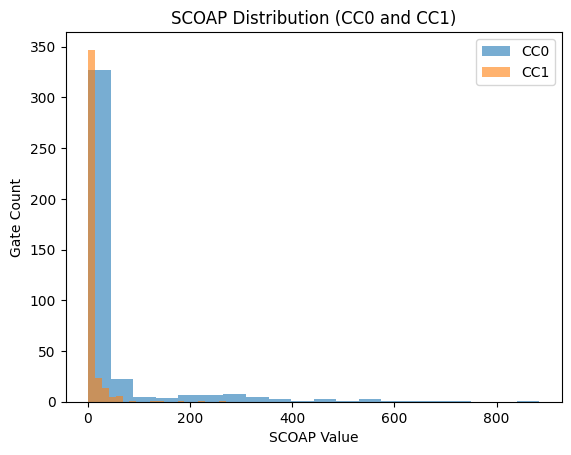

In [ ]:
import matplotlib.pyplot as plt

plt.hist(cc0_dist, bins=20, alpha=0.6, label='CC0')
plt.hist(cc1_dist, bins=20, alpha=0.6, label='CC1')
plt.title("SCOAP Distribution (CC0 and CC1)")
plt.xlabel("SCOAP Value")
plt.ylabel("Gate Count")
plt.legend()
plt.show()


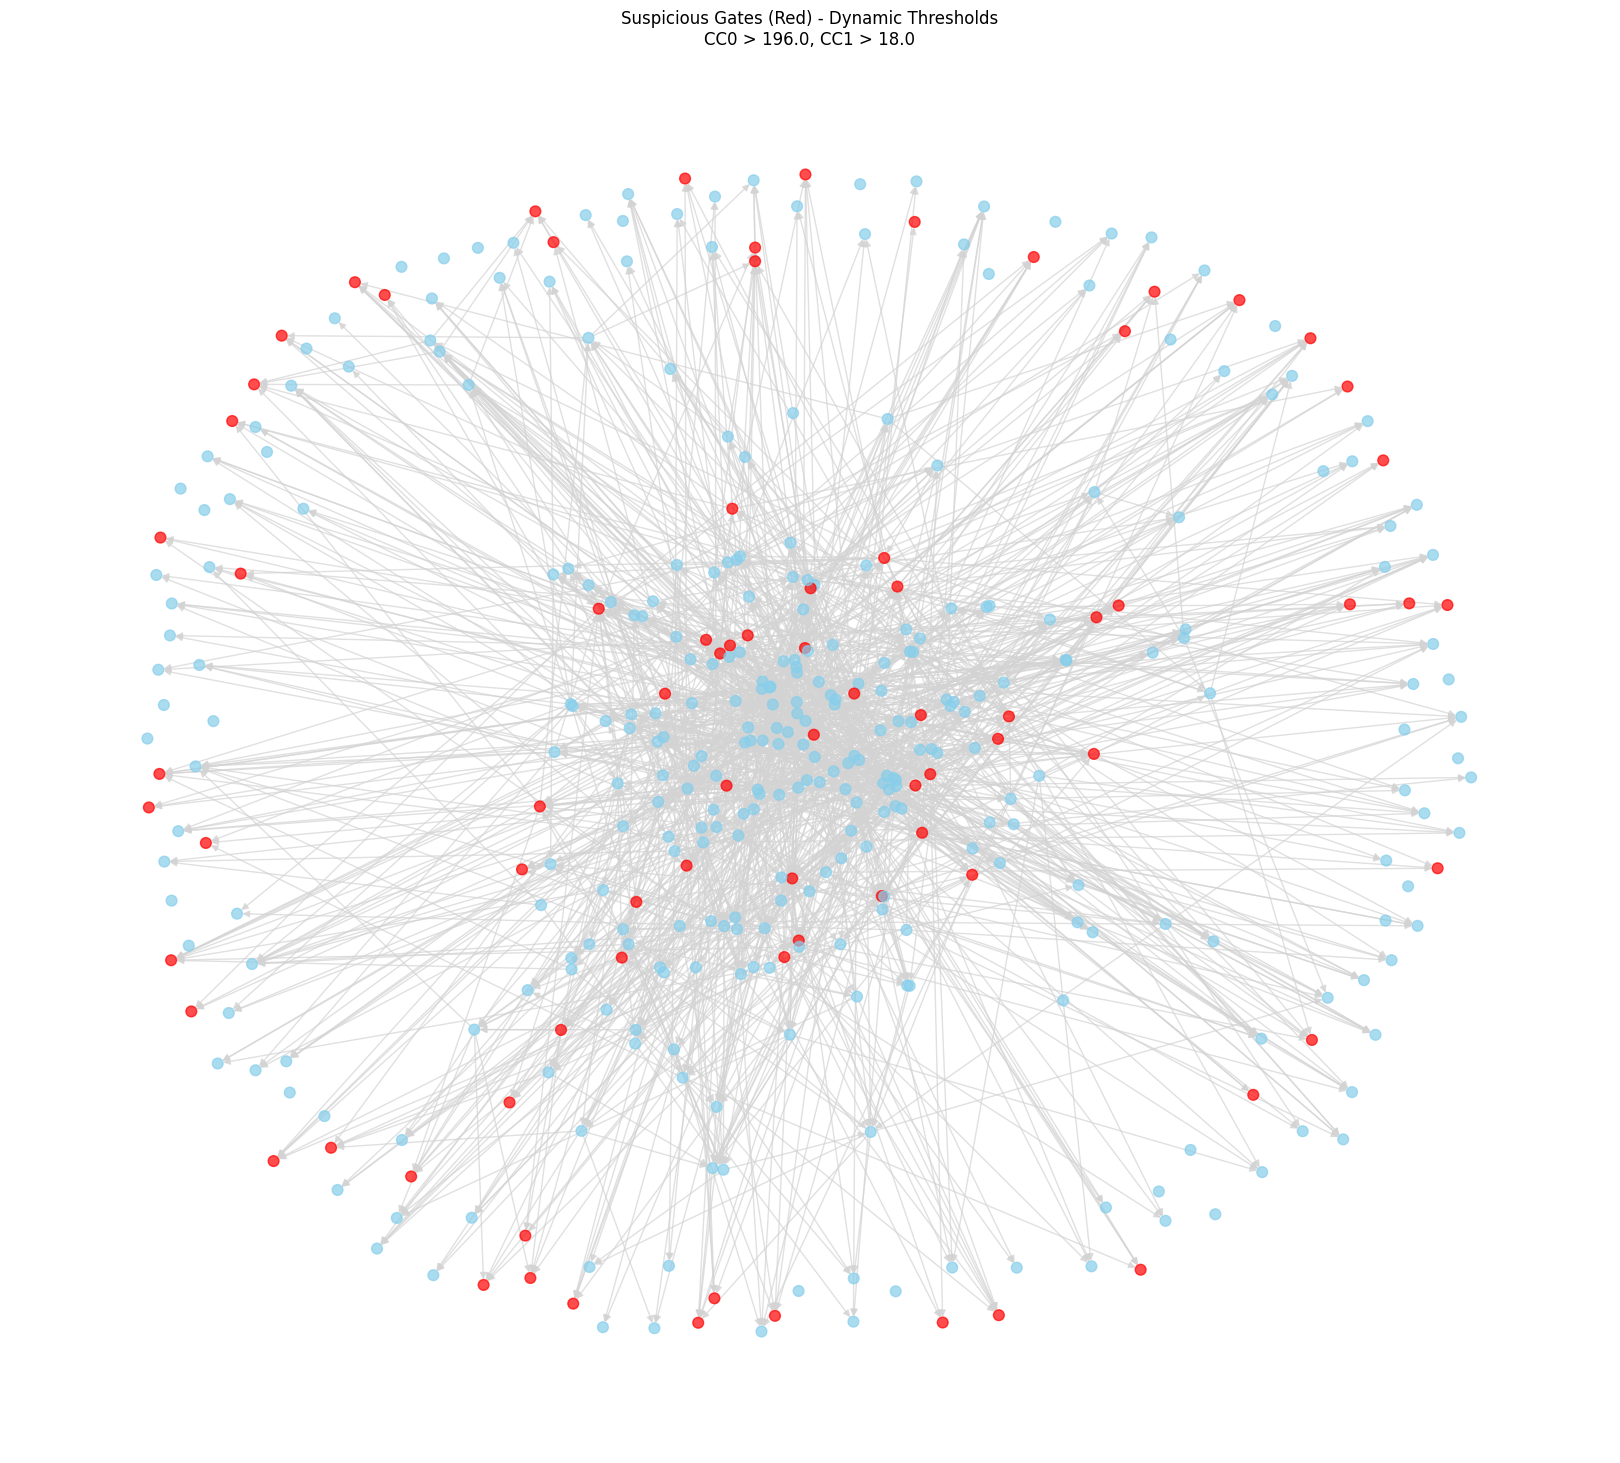

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Subgraph of gate nodes only
gate_nodes = [n for n in G.nodes if G.nodes[n].get('gate_type')]
H = G.subgraph(gate_nodes)

# Prepare node colors based on previously flagged suspicious gates
suspicious_set = set([g[0] for g in suspicious_gates])
node_colors = ['red' if node in suspicious_set else 'skyblue' for node in H.nodes]

# Layout and plot
pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(16, 14))
nx.draw(
    H, pos,
    with_labels=False,
    node_size=60,  # enlarged node size for better clarity
    node_color=node_colors,
    edge_color='lightgray',  # lighter connections
    alpha=0.7
)

# Use earlier threshold values
cc0_array = np.array(cc0_dist)
cc1_array = np.array(cc1_dist)

cc0_thresh = max(2 * np.mean(cc0_vals), np.percentile(cc0_vals, 90))
cc1_thresh = max(2 * np.mean(cc1_vals), np.percentile(cc1_vals, 90))


plt.title(f"Suspicious Gates (Red) - Dynamic Thresholds\nCC0 > {cc0_thresh}, CC1 > {cc1_thresh}")
plt.show()


In [ ]:
def compute_observability(G, cc0, cc1):
    co = {}

    # Step 1: Identify primary outputs (POs) → nodes with out-degree 0
    primary_outputs = [n for n in G.nodes if G.out_degree(n) == 0 and G.nodes[n].get('gate_type')]

    # Step 2: Initialize CO values at primary outputs to 0
    for node in G.nodes:
        co[node] = float('inf')
    for po in primary_outputs:
        co[po] = 0

    # Step 3: Reverse topological order to compute observability bottom-up
    reverse_topo = list(reversed(list(nx.topological_sort(G))))

    for node in reverse_topo:
        successors = list(G.successors(node))
        if not successors:
            continue  # Skip if no fanout

        # Compute CO as the minimum of successors' CO + logic effort
        min_co = float('inf')
        for succ in successors:
            succ_co = co[succ]
            # Assume the gate is two-input for simplicity (adjust if needed)
            if cc0[node] is not None and cc1[node] is not None:
                logic_effort = min(cc0[succ], cc1[succ]) + 1
                min_co = min(min_co, succ_co + logic_effort)

        if min_co < float('inf'):
            co[node] = min_co

    return co


In [ ]:

co = compute_observability(G, cc0, cc1)

# Print a few samples
print("Sample Observability Values:")
for i, node in enumerate(list(co.keys())[:10]):
    print(f"{node}: CO = {co[node]}")


Sample Observability Values:
U3: CO = 0
U4: CO = 2
U5: CO = 3
U6: CO = 0
U7: CO = 0
U9: CO = 0
U11: CO = 0
U12: CO = 0
U13: CO = 0
U15: CO = 2


Thresholds → CC0: 196.00, CC1: 18.00, CO: 7.31
Suspicious gates found: 83
Sample suspicious gates: ['U4', 'U5', 'U6', 'U9', 'U17', 'U18', 'U21', 'U24', 'U25', 'U27', 'U29', 'U31', 'U32', 'U33', 'U39', 'U41', 'U45', 'U47', 'U49', 'U50', 'U60', 'U63', 'U64', 'U71', 'U79', 'U83', 'U105', 'U110', 'U113', 'U123', 'U133', 'U136', 'U139', 'U152', 'U159', 'U161', 'U164', 'U165', 'U173', 'U175', 'U176', 'U183', 'U188', 'U190', 'U191', 'U197', 'U198', 'U200', 'U202', 'U203', 'U209', 'U217', 'U219', 'U222', 'U228', 'U235', 'U239', 'U243', 'U270', 'U286', 'U289', 'U291', 'U296', 'U297', 'U301', 'U306', 'U307', 'U309', 'U331', 'U337', 'U340', 'U352', 'U8', 'U10', 'U20', 'U23', 'U51', 'U52', 'U59', 'U65', 'U81', 'U172', 'U237']


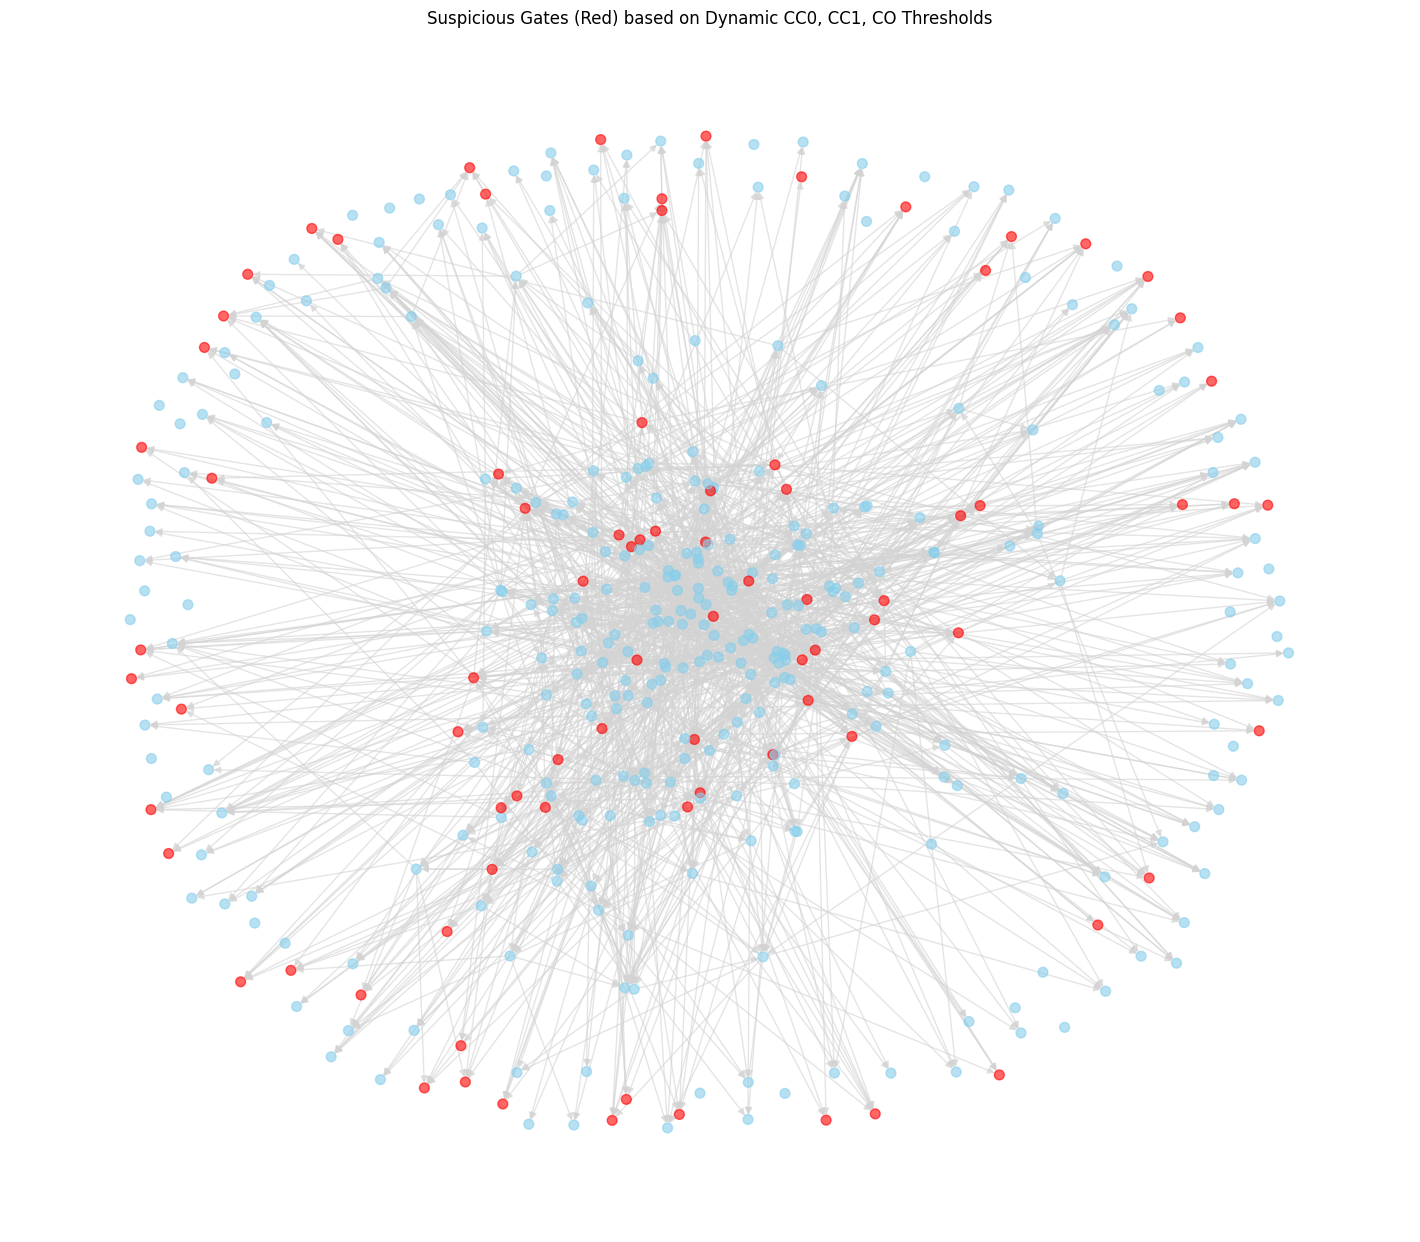

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Extract values
cc0_vals = [v for v in cc0.values() if v > 0]
cc1_vals = [v for v in cc1.values() if v > 0]
co_vals  = [v for v in co.values()  if v > 0]

# Dynamic thresholds
cc0_thresh = max(2 * np.mean(cc0_vals), np.percentile(cc0_vals, 90))
cc1_thresh = max(2 * np.mean(cc1_vals), np.percentile(cc1_vals, 90))
co_thresh  = max(2 * np.mean(co_vals),  np.percentile(co_vals, 90))

print(f"Thresholds → CC0: {cc0_thresh:.2f}, CC1: {cc1_thresh:.2f}, CO: {co_thresh:.2f}")

# Identify suspicious gates
suspicious_gates = []
for node in G.nodes:
    if not G.nodes[node].get("gate_type"):
        continue
    if cc0.get(node, 0) > cc0_thresh or cc1.get(node, 0) > cc1_thresh or co.get(node, 0) > co_thresh:
        suspicious_gates.append(node)

print(f"Suspicious gates found: {len(suspicious_gates)}")
print("Sample suspicious gates:", suspicious_gates[:83])

# --- Visualization ---
gate_nodes = [n for n in G.nodes if G.nodes[n].get('gate_type')]
H = G.subgraph(gate_nodes)

node_colors = ['red' if n in suspicious_gates else 'skyblue' for n in H.nodes]
pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(14, 12))
nx.draw(
    H, pos,
    with_labels=False,
    node_size=50,
    node_color=node_colors,
    edge_color='lightgray',
    alpha=0.6
)
plt.title("Suspicious Gates (Red) based on Dynamic CC0, CC1, CO Thresholds")
plt.show()


Thresholds → CC0: 196.00, CC1: 18.00, CO: 7.31
Suspicious CC: 80 | CO: 3 | Both: 0


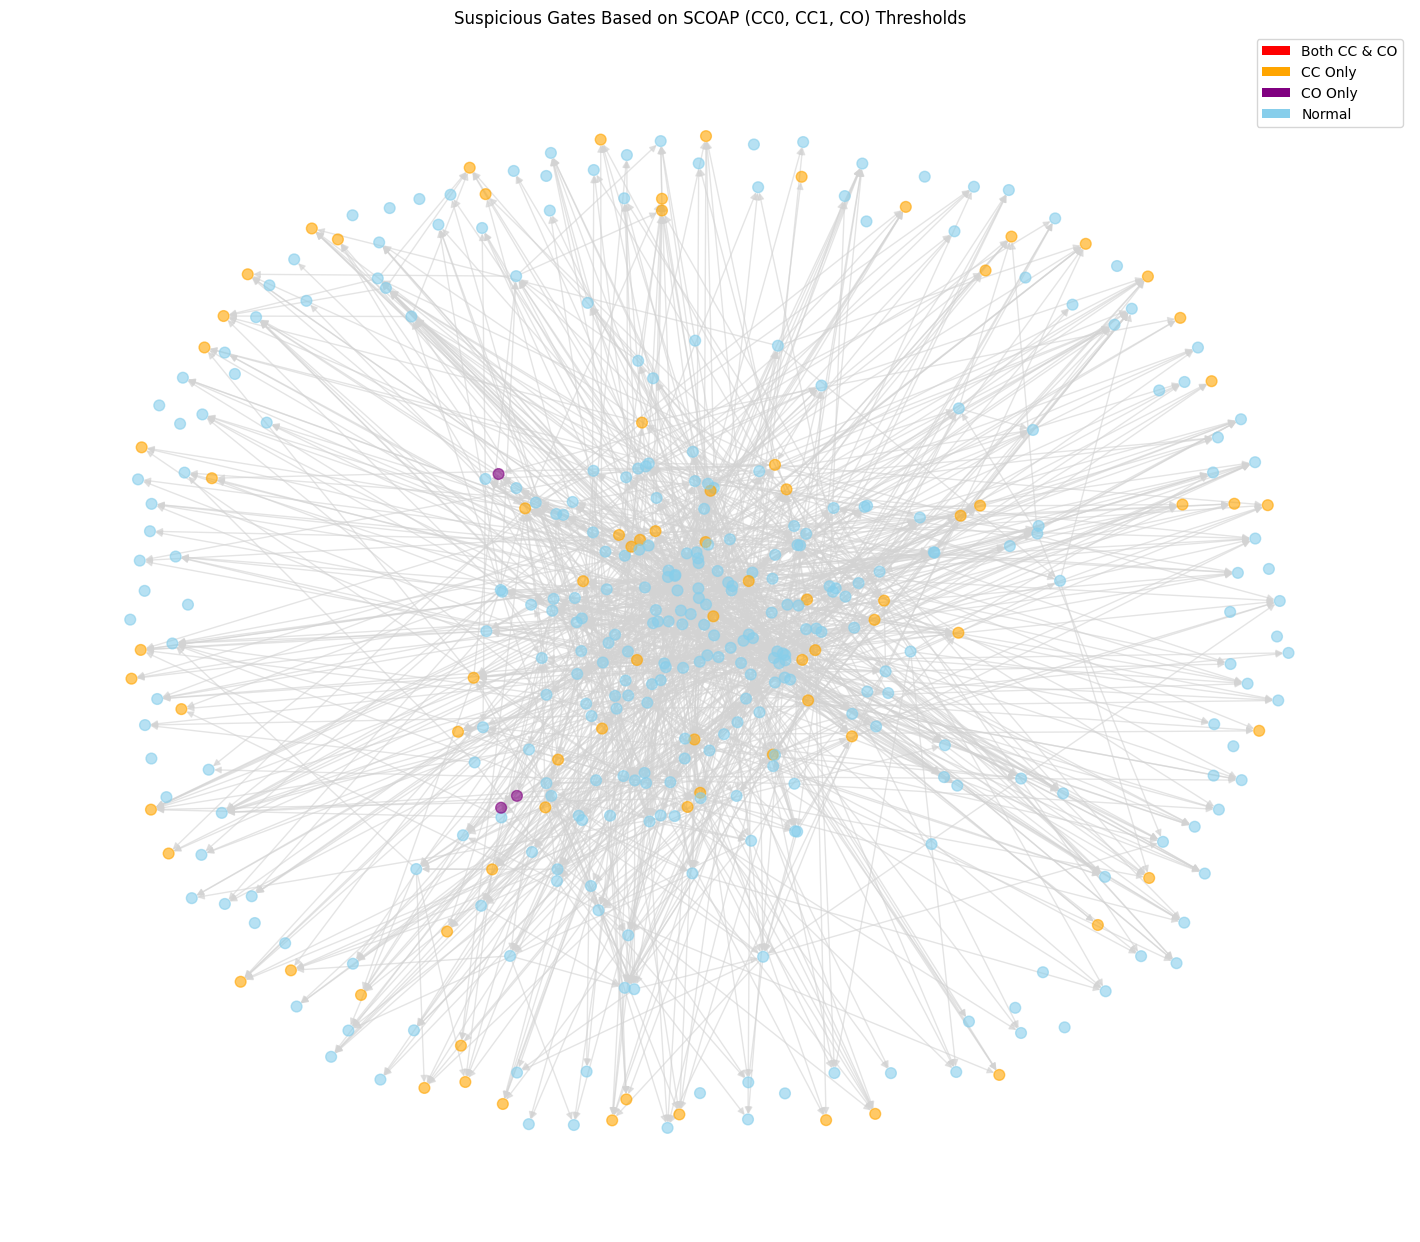

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Threshold calculation
cc0_vals = [v for v in cc0.values() if v > 0]
cc1_vals = [v for v in cc1.values() if v > 0]
co_vals  = [v for v in co.values()  if v > 0]

cc0_thresh = max(2 * np.mean(cc0_vals), np.percentile(cc0_vals, 90))
cc1_thresh = max(2 * np.mean(cc1_vals), np.percentile(cc1_vals, 90))
co_thresh  = max(2 * np.mean(co_vals),  np.percentile(co_vals, 90))

print(f"Thresholds → CC0: {cc0_thresh:.2f}, CC1: {cc1_thresh:.2f}, CO: {co_thresh:.2f}")

# Identify suspicious gates
suspicious_cc = set()
suspicious_co = set()

for node in G.nodes:
    if not G.nodes[node].get("gate_type"):
        continue
    if cc0.get(node, 0) > cc0_thresh or cc1.get(node, 0) > cc1_thresh:
        suspicious_cc.add(node)
    if co.get(node, 0) > co_thresh:
        suspicious_co.add(node)

suspicious_both = suspicious_cc & suspicious_co
cc_only = suspicious_cc - suspicious_both
co_only = suspicious_co - suspicious_both

print(f"Suspicious CC: {len(suspicious_cc)} | CO: {len(suspicious_co)} | Both: {len(suspicious_both)}")

# Subgraph of gate nodes only
gate_nodes = [n for n in G.nodes if G.nodes[n].get('gate_type')]
H = G.subgraph(gate_nodes)

# Color assignment
node_colors = []
for node in H.nodes:
    if node in suspicious_both:
        node_colors.append('red')
    elif node in cc_only:
        node_colors.append('orange')
    elif node in co_only:
        node_colors.append('purple')
    else:
        node_colors.append('skyblue')

# Draw graph
pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(14, 12))
nx.draw(
    H, pos,
    with_labels=False,
    node_size=60,
    node_color=node_colors,
    edge_color='lightgray',
    alpha=0.6
)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Both CC & CO'),
    Patch(facecolor='orange', label='CC Only'),
    Patch(facecolor='purple', label='CO Only'),
    Patch(facecolor='skyblue', label='Normal')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.title("Suspicious Gates Based on SCOAP (CC0, CC1, CO) Thresholds")
plt.show()


In [ ]:
gate_nodes = [n for n in G.nodes if G.nodes[n].get('gate_type')]
print(f"Total gate nodes: {len(gate_nodes)}")


Total gate nodes: 401


In [ ]:
print("Total parsed gate nodes:", len([n for n in G.nodes if G.nodes[n].get('gate_type')]))


Total parsed gate nodes: 401


In [ ]:
total_nodes = len(G.nodes)
gate_nodes = [n for n in G.nodes if G.nodes[n].get('gate_type')]

print(f"Total nodes in G: {total_nodes}")
print(f"Gate nodes in G: {len(gate_nodes)}")


Total nodes in G: 401
Gate nodes in G: 401
